In [3]:
import numpy as np
import scipy
import chumpy as ch       # pip install git+https://github.com/scottandrews/chumpy.git@fe51783e0364bf1e9b705541e7d77f894dd2b1ac
import pickle
import sys
import cv2 as cv

def write_int(file, val):
    file.write(int(val).to_bytes(4, byteorder=sys.byteorder))

def write_arr(file, arr):
    file.write(arr.tobytes())

class Mano:
    def __init__(self, path):
        self.path = path
        self._read()

    def print_data_format(self, data):
        """Useful for understanding stored data format in pkl file"""
        for key, value in data.items():
            print(f"{key}:\t{type(value)}", end=" ")
            if isinstance(value, np.ndarray):
                print(value.shape)
            elif isinstance(value, scipy.sparse.csc.csc_matrix):
                print(value.shape)
            elif isinstance(value, str):
                print(value)
            elif isinstance(value, ch.reordering.Select):
                print(value.shape)

        # output:
        # hands_components:   <class 'numpy.ndarray'> (45, 45) each row is a basis vector i.e. 45 basis vectors in 45 dimension
        # f:                  <class 'numpy.ndarray'> (1538, 3) faces
        # J_regressor:        <class 'scipy.sparse.csc.csc_matrix'> (16, 778)
        # kintree_table:      <class 'numpy.ndarray'> (2, 16) [:,i]=[parent[i],i]
        # J:                  <class 'numpy.ndarray'> (16, 3)
        # bs_style:           <class 'str'> lbs
        # hands_coeffs:       <class 'numpy.ndarray'> (1554, 45) what is this?
        # weights:            <class 'numpy.ndarray'> (778, 16)
        # posedirs:           <class 'numpy.ndarray'> (778, 3, 135) pose blends
        # hands_mean:         <class 'numpy.ndarray'> (45,)
        # v_template:         <class 'numpy.ndarray'> (778, 3)
        # shapedirs:          <class 'chumpy.reordering.Select'> (778, 3, 10) shape blends
        # bs_type:            <class 'str'> lrotmin

    def _read(self):
        """Reads MANO data from pkl file."""
        with open(self.path, "rb") as file:
            data = pickle.load(file, encoding="latin1")

        
        # parameters required (names as per paper)
        self.V_temp = data["v_template"]
        self.J_reg = data["J_regressor"]
        self.S = np.array(data["shapedirs"])
        self.P = data["posedirs"]
        self.W = data["weights"]

        # pose pca parameters
        self.pose_pca_basis = data["hands_components"]
        self.pose_pca_mean = data["hands_mean"]
        self.data_pose_pca_coeffs = data["hands_coeffs"]

        # supporting parameters
        self.triangles = data["f"]
        self.parent = data["kintree_table"][0].astype(np.int32)

        # dependent parameters
        self.n_joints = self.J_reg.shape[0]
        self.n_vertices = self.V_temp.shape[0]
        self.n_triangles = self.triangles.shape[0] 

        # n_comps = 7
        # hands_components = data["hands_components"]
        # hands_mean = data["hands_mean"]
        # hands_coeffs = data["hands_coeffs"]
        # selected_components = hands_components[:n_comps]
        # pose_coeffs = np.zeros(3+n_comps)   # 3: global orientation
        # full_hand_pose = pose_coeffs[3:].dot(selected_components)
        # print(hands_coeffs[1000])

In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import json
import cv2
import tensorflow as tf
from tensorflow import keras
import os
from os import path
import datetime
from glob import glob
import time
import scipy

In [2]:
# Global Constants
EPSILON = 0.0001
AUGMENT = 1
PAD = 30
SEQ_LENGTH = 8              ##Spiral convolulational neighbourhood length
OUT_IMAGE_SIZE = (224, 224) ## Paper says 192x192 crops

CROP_OFFSET_RANGE = [-5, 5]
ROTATION_RANGE = [-180, 180]

## Hyperparameters
lamb_edge = 0.01
lamb_vert = 0.01
learning_rate = 1e-3
boundaries = [100, 150, 200, 250]
lr_values = [learning_rate, learning_rate*0.1, learning_rate*0.01, learning_rate*0.001, learning_rate*0.0001]

storage_dir = "../storage/"
data_dir = storage_dir + "data/"
log_dir = storage_dir + "logs/"
chkpts_dir = "../chkpts/"
meta_dir = storage_dir + "metadata/"

imagenet_mean=np.array([0.485, 0.456, 0.406])
imagenet_std=np.array([0.229, 0.224, 0.225])

In [4]:
tf.debugging.experimental.enable_dump_debug_info(log_dir, tensor_debug_mode="FULL_HEALTH", circular_buffer_size=-1)

INFO:tensorflow:Enabled dumping callback in thread MainThread (dump root: ../storage/logs/, tensor debug mode: FULL_HEALTH)


In [5]:
tf.debugging.disable_check_numerics()

In [6]:
def bounding_box(points, augment=1):
    """
    Get the hand's bounding box based on annotation coordinates
    """
    x_coordinates, y_coordinates, z_coordinates = zip(*points)
    random_offsets = np.random.randint(*CROP_OFFSET_RANGE, (2, 3))
    return np.array([[min(x_coordinates), min(y_coordinates), min(z_coordinates)], [max(x_coordinates), max(y_coordinates), max(z_coordinates)]])+random_offsets*augment

In [7]:
def translation_mat(tx=0, ty=0, tz=0):
    """
    4x4 translational matrix
    """
    mat = np.eye(4)
    mat[0:3, 3] = np.array([tx, ty, tz]).T
    return mat

In [8]:
def scaling_mat(sx=1, sy=1, sz=1):
    """
    4x4 scaling matrix
    """
    return np.diag([sx, sy, sz, 1])

In [9]:
def shift_vertices(vertex_set, augment=1, pad=PAD):
    """
    Shift vertices based on the crop of hand from image
    """
    bbx = bounding_box(vertex_set).astype(int)
    mat = translation_mat(*(-1*(bbx[0,:]-pad)))
#     print(mat)
    adjusted_vertices = np.hstack([vertex_set.copy(), np.ones((len(vertex_set), 1))])
    adjusted_vertices = (adjusted_vertices @ mat.T)
    return adjusted_vertices, mat, bbx

In [10]:
def flip_hand(adjusted_vertices, mat, cropped_image, is_left):
    """
    Flip left hand to mirrored right hand coordinates
    """
    flip_mat = np.eye(4)
    if is_left:
        cropped_image = cropped_image[:, -1::-1, :]
        flip_mat = translation_mat(cropped_image.shape[1])
        flip_mat[0, 0] = -1
        adjusted_vertices = adjusted_vertices @ flip_mat.T
    return cropped_image, adjusted_vertices, flip_mat

In [11]:
def crop_image(image, width, height, bbx, pad=PAD):
    image = np.asarray(image.resize((width, height), 2))
    cropped_image = image[bbx[0][1]-pad:bbx[1][1]+pad, bbx[0][0]-pad:bbx[1][0]+pad, :]
    return cropped_image

In [12]:
def visualize_in_orig_image(image_path, width, height, annotations):
    """
    Visualize hand annotations and image on uncropped image
    """
    image = Image.open(image_path)
    image = image.resize((width, height), 2)
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    vertices = np.array(annotations['vertices'])
    plt.plot(vertices[:, 0], vertices[:, 1], 'o', color='green', markersize=1)
    plt.show()

In [13]:
def visualize_in_processed_image(image_path, width, height, annotations):
    """
    Visualize hand annotations and image on cropped image
    """
    image = Image.open(image_path)
    image = image.resize((width, height), 2)
    adjusted_vertices, mat, bbx = shift_vertices(annotations['vertices'])
    cropped_image = crop_image(image, width, height, bbx)
    plt.imshow(cropped_image)
    vertices = np.array(adjusted_vertices)
    plt.plot(adjusted_vertices[:, 0], adjusted_vertices[:, 1], 'o', color='green', markersize=1)
    plt.show()

In [14]:
# def viz_3d(vertices, faces):
#     import open3d as o3d
    
#     mesh = o3d.geometry.TriangleMesh(o3d.utility.Vector3dVector(vertices), o3d.utility.Vector3iVector(faces))
#     o3d.visualization.draw_geometries([mesh])

In [15]:
def plot_and_show(image, vertex_set=None):
    """
    Visualize already cropped image and annotations
    """
    plt.imshow(image)
    if vertex_set is not None:
        plt.plot(vertex_set[:, 0], vertex_set[:, 1], 'o', color='green', markersize=1)
    plt.show()

In [16]:
def plot_vertices(vertex_set):
    """
    Plot just vertices as a 2D image
    """
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(vertex_set[:, 0], vertex_set[:, 1], "go")
#     ax.set_xlim(-1, 1)
#     ax.set_ylim(1, -1)
    ax.set_aspect("equal")
    ax.invert_yaxis()
    plt.show()

In [17]:
def viz_3d(vert, faces):
    """
    Plot just vertices as a 3D image
    """
    mesh = Mesh(v=vert, f=faces)
    time.sleep(0.5)
    viewer = mesh.show()
    return 0

In [18]:
def map_img_to_path(img_dct, images):
    """
    Preprocessing function to create a image id to details mapping
    """
    for i in images:
        if i['id'] not in img_dct:
            img_dct[i['id']] = {}
        img_dct[i['id']]['path'] = i['name']
        img_dct[i['id']]['width'] = i['width']
        img_dct[i['id']]['height'] = i['height']

In [19]:
def map_img_to_ann(img_dct, annotations):
    """
    Preprocessing function to create a image id to list of annotations
    """
    for idx, ann in enumerate(annotations):
        if ann['image_id'] not in img_dct:
            img_dct[ann['image_id']] = {}
        if 'ann' not in img_dct[ann['image_id']]:
            img_dct[ann['image_id']]['ann'] = []
        img_dct[ann['image_id']]['ann'].append(idx)

In [20]:
def retrieve_sample(data, image_name):
    """
    Retrieve annotation for a particular image
    """
    annotation_list = []
    image = None
    for im in data['images']:
        if im['name'] == image_name:
            image = im
    
    for ann in data['annotations']:
        if ann['image_id'] == image['id']:
            annotation_list.append(ann)

    return annotation_list, image

In [21]:
def get_edge_mat(face_data, num_vert):
    """
    Get edge matrix of dimension Num_edges x Num_vertices
    Example :- [[1, 0, 0, -1, 0...], .. .. ]
    """
    edge_list = []
    for f in face_data:
        edge_list.append((f[0], f[1]) if f[0]<f[1] else (f[1], f[0]))
        edge_list.append((f[1], f[2]) if f[1]<f[2] else (f[2], f[1]))
        edge_list.append((f[2], f[0]) if f[2]<f[0] else (f[0], f[2]))
    edge_list = list(set(edge_list))
    # print(edge_list)
    edge_mat = np.zeros((len(edge_list), num_vert))
    for idx, e in enumerate(edge_list):
        edge_mat[idx, e[0]]=1
        edge_mat[idx, e[1]]=-1
    return edge_mat

In [22]:
# Load full dataset
with open(storage_dir+'YouTube-3D-Hands/youtube_train.json') as f:
    sample_train_data = json.load(f)

In [23]:
# with open(storage_dir+'sample.json') as f:
#     sample_train_data = json.load(f)

In [24]:
train_data = sample_train_data

In [25]:
print( len(train_data["annotations"]), len(train_data["images"]))

47125 44827


In [26]:
print("Data keys:", [k for k in train_data.keys()])
print("Image keys:", [k for k in train_data['images'][0].keys()])
print("Annotations keys:", [k for k in train_data['annotations'][0].keys()])

print("The number of images:", len(train_data['images']))
print("The number of annotations:", len(train_data['annotations']))

Data keys: ['images', 'annotations']
Image keys: ['width', 'name', 'height', 'id']
Annotations keys: ['vertices', 'is_left', 'image_id', 'id']
The number of images: 44827
The number of annotations: 47125


In [27]:
train_img_to_ann = {}
map_img_to_path(train_img_to_ann, train_data['images'])
map_img_to_ann(train_img_to_ann, train_data['annotations'])

In [75]:
# Get the cropped image at this stage
annotation_list, image  = retrieve_sample(train_data, 'youtube/r8JzYdt2ivI/video/frames/4390.png')

In [76]:
image

{'width': 1920,
 'name': 'youtube/r8JzYdt2ivI/video/frames/4390.png',
 'height': 1080,
 'id': 4227}

In [77]:
# annotation_list

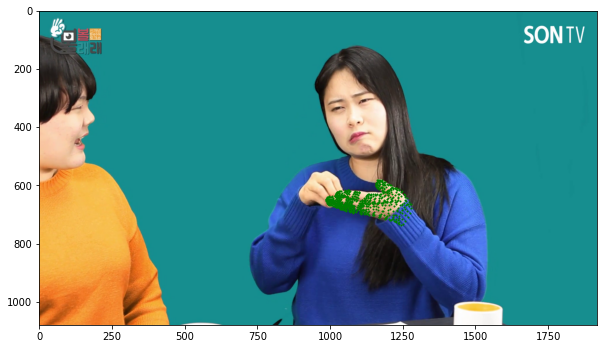

In [78]:
visualize_in_orig_image(data_dir+image['name'], image['width'], image['height'], annotation_list[0])

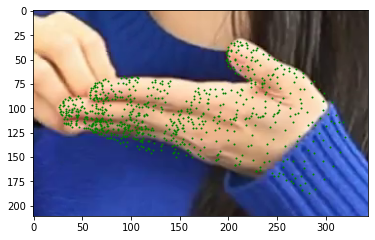

In [79]:
visualize_in_processed_image(data_dir+image['name'], image['width'], image['height'], annotation_list[0])

In [80]:
# Process vertex set and image (Pipeline for a single image)
shifted_vertices, mat, bbx = shift_vertices(annotation_list[0]['vertices'])
orig_image = Image.open(data_dir+image['name'])
resized_image = orig_image.resize((image['width'], image['height']), 2)
cropped_image = crop_image(resized_image, image['width'], image['height'], bbx)

cropped_image, flipped_vertices, flip_mat = flip_hand(shifted_vertices, mat, cropped_image, 1)

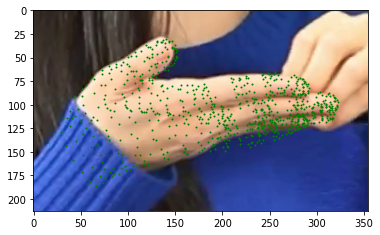

In [81]:
plot_and_show(cropped_image, flipped_vertices)

In [82]:
width = cropped_image.shape[1]
height = cropped_image.shape[0]
# print(width, height)

large_side = max(width, height)
scale = OUT_IMAGE_SIZE[0] / large_side

# image = image.thumbnail(OUT_IMAGE_SIZE, Image.ANTIALIAS)
scaled_image = Image.fromarray(cropped_image).resize((int(scale * width), int(scale * height)), 2)
# print(width*scale, height*scale)

scale_mat = scaling_mat(scale, scale)
width_padding = int(OUT_IMAGE_SIZE[0] - scale * width)
height_padding = int(OUT_IMAGE_SIZE[0] - scale * height)

pad_mat = translation_mat( width_padding/2, height_padding/2)
padded_image = Image.new("RGB", OUT_IMAGE_SIZE)
padded_image.paste(scaled_image, (width_padding//2, height_padding//2))

scaled_vertices = flipped_vertices @ scale_mat.T
padded_vertices = scaled_vertices @ pad_mat.T

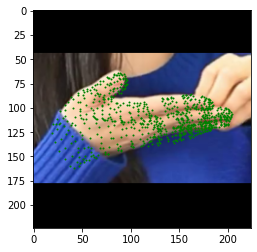

In [83]:
plot_and_show(padded_image, padded_vertices)

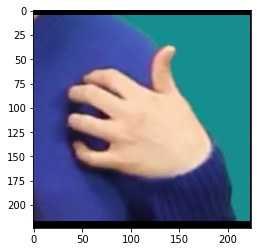

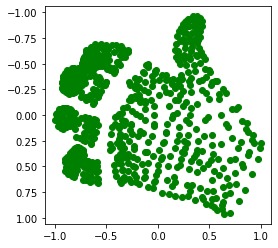

In [37]:
new_bbx = bounding_box(padded_vertices[:, 0:3], 0)
padded_image = np.array(padded_image)
normalized_image = padded_image / 255
# print(normalized_image.max())
plot_and_show(normalized_image)

vertex_scale = new_bbx[1, :] - new_bbx[0, :]
vertex_scale[:] = vertex_scale.max()/2
normalize_mat = (translation_mat(*((- new_bbx[0, :] - new_bbx[1, :])/2)).T @
                    scaling_mat(*(1/(vertex_scale+EPSILON))).T).T
normalized_vertices = padded_vertices @ normalize_mat.T

plot_vertices(normalized_vertices)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
[[ -0.78580152  -0.75319823 284.36797201]
 [  0.75319823  -0.78580152 115.65156833]]


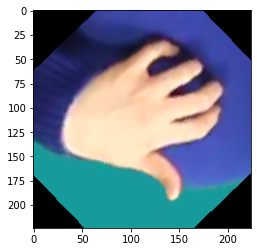

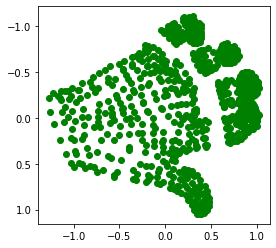

In [38]:
# Random rotation and scale
random_angle_in_degrees = np.random.rand() * (ROTATION_RANGE[1]-ROTATION_RANGE[0]) - ROTATION_RANGE[0]
random_scale = np.random.rand()*0.1 + 1.0
cv_mat_rot_scale = cv2.getRotationMatrix2D((OUT_IMAGE_SIZE[0]/2, OUT_IMAGE_SIZE[1]/2), random_angle_in_degrees, random_scale)
rotated_and_scaled_image = cv2.warpAffine(normalized_image, cv_mat_rot_scale, OUT_IMAGE_SIZE, borderValue=0, flags=cv2.INTER_NEAREST)
rotated_and_scaled_image *= random_scale

print(cv_mat_rot_scale)
mat_rot_scale = np.eye(4, dtype=np.float32)
mat_rot_scale[:2, :2] = cv_mat_rot_scale[:2, :2]
rotated_scaled_vertices = normalized_vertices @ mat_rot_scale.T
plot_and_show(rotated_and_scaled_image)
plot_vertices(rotated_scaled_vertices)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


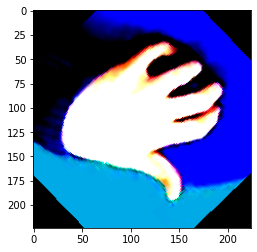

In [39]:
## Dataset Normalization (Images)
intensity_normalized_image = (rotated_and_scaled_image - imagenet_mean)/imagenet_std
plot_and_show(intensity_normalized_image)
## Normalize anns using dataset stats

In [97]:
def process_data_wrapper(image_path, image_width, image_height, hand_is_left, annotation_idx, augment):
    #Load these in process_ds for parallelisation
    annotations = train_data['annotations'][annotation_idx.numpy()]['vertices']
    image = Image.open(image_path.numpy())

    image_height = image_height.numpy()
    image_width = image_width.numpy()
    hand_is_left = hand_is_left.numpy()
    # image = image.resize((image_width, image_height), 2)
    
    annotations_uvd, normalized_image, normalized_annotations, affine_mat = process_data(image, image_width, image_height, hand_is_left, annotations, augment)
    
    return annotations_uvd, normalized_image, normalized_annotations, affine_mat

In [98]:
def process_data(image, image_width, image_height, hand_is_left, annotation, augment):
    shifted_vertices, mat, bbx = shift_vertices(annotation, augment)
    resized_image = image.resize((image_width, image_height), 2)
    cropped_image = crop_image(resized_image, image_width, image_height, bbx)

    cropped_image, flipped_vertices, flip_mat = flip_hand(shifted_vertices, mat, cropped_image, hand_is_left)
    
    width = cropped_image.shape[1]
    height = cropped_image.shape[0]

    large_side = max(width, height)
    scale = OUT_IMAGE_SIZE[0] / large_side

    scaled_image = Image.fromarray(cropped_image).resize((int(scale * width), int(scale * height)), 2)

    scale_mat = scaling_mat(scale, scale)
    width_padding = int(OUT_IMAGE_SIZE[0] - scale * width)
    height_padding = int(OUT_IMAGE_SIZE[0] - scale * height)

    pad_mat = translation_mat( width_padding/2, height_padding/2)
    padded_image = Image.new("RGB", OUT_IMAGE_SIZE)
    padded_image.paste(scaled_image, (width_padding//2, height_padding//2))

    scaled_vertices = flipped_vertices @ scale_mat.T
    padded_vertices = scaled_vertices @ pad_mat.T
    
    new_bbx = bounding_box(padded_vertices[:, 0:3], 0)
    padded_image = np.array(padded_image)
    normalized_image = padded_image / 255.0
    
    vertex_scale = new_bbx[1, :] - new_bbx[0, :]
    vertex_scale[:] = vertex_scale.max()/2
    normalize_mat = (translation_mat(*((- new_bbx[0, :] - new_bbx[1, :])/2)).T @
                        scaling_mat(*(1/(vertex_scale+EPSILON))).T).T

    #### IMP How to dataset normalize annotations ???
    normalized_vertices = padded_vertices @ normalize_mat.T
    
    if augment:
        random_angle_in_degrees = np.random.rand() * (ROTATION_RANGE[1]-ROTATION_RANGE[0]) - ROTATION_RANGE[0]
    else:
        random_angle_in_degrees = 0

    cv_mat_rot = cv2.getRotationMatrix2D((OUT_IMAGE_SIZE[0]/2, OUT_IMAGE_SIZE[1]/2), random_angle_in_degrees, 1)
    rotated_image = cv2.warpAffine(normalized_image, cv_mat_rot, OUT_IMAGE_SIZE, borderValue=0, flags=cv2.INTER_NEAREST)
    
    intensity_normalized_image = (rotated_image - imagenet_mean) / imagenet_std
    
    
    mat_rot = np.eye(4, dtype=np.float32)
    if augment:
        mat_rot[:2, :2] = cv_mat_rot[:2, :2]
    rotated_vertices = normalized_vertices @ mat_rot.T
    
    affine_mat = mat_rot @ pad_mat @ scale_mat @ flip_mat @ mat
    return annotation, normalized_image, normalized_vertices[:, :3], affine_mat[:3, :3]

In [99]:
def get_raw_data_as_tf_dataset(storage_dir, images, annotations):
    image_dct = {}
    image_path = []
    image_width = []
    image_height = []
    hand_is_left = []
    annotation_idx = []
    map_img_to_path(image_dct, images)
    map_img_to_ann(image_dct, annotations)
    for idx, img in enumerate(image_dct.keys()):
        image_dct[img]['path'] = os.path.join(data_dir, image_dct[img]['path'])
        for ann in image_dct[img]['ann']:
            if path.exists(image_dct[img]['path']):
                image_path.append(image_dct[img]['path'])
                image_width.append(image_dct[img]['width'])
                image_height.append(image_dct[img]['height'])
                hand_is_left.append(annotations[ann]['is_left'])
                annotation_idx.append(ann)

            # if len(image_path)==101:
            #     print(image_dct[img]['path'])
        # if idx >= 1:
        #     break
        
    
    ds_raw = tf.data.Dataset.from_tensor_slices((image_path, image_width, image_height, hand_is_left, annotation_idx))

    return ds_raw

In [100]:
def process_ds(image_path, image_width, image_height, hand_is_left, annotation_idx, augment):
    #Load image and annotations from text file later
    
    annotations_uvd, normalized_image, normalized_annotations, affine_mat = tf.py_function(
        func = process_data_wrapper,
        inp = [image_path, image_width, image_height, hand_is_left, annotation_idx, augment],
        Tout = [tf.float32, tf.float32, tf.float32, tf.float32]
    )
    
    annotations_uvd.set_shape([778, 3])
    normalized_image.set_shape([OUT_IMAGE_SIZE[0], OUT_IMAGE_SIZE[1], 3])
    normalized_annotations.set_shape([778, 3])
    affine_mat.set_shape([3, 3])
    
#     return (
#         {"normalized_image" : normalized_image, "affine_mat" : affine_mat},
#         {"normalized_annotations" : normalized_annotations, "annotations_uvd" : annotations_uvd}
#     )
    return normalized_image, normalized_annotations

In [106]:
def process_tf_dataset(ds_raw, augment):
    ds_processed = ds_raw.map(lambda image_path, image_width, image_height, hand_is_left, annotation_id : process_ds(image_path, image_width, image_height, hand_is_left, annotation_id, augment))
    ds_processed = ds_processed.apply(tf.data.experimental.ignore_errors())

    return ds_processed

In [107]:
def get_processed_dataset_as_tf_dataset(storage_dir, images, annotations):
    ds_raw = get_raw_data_as_tf_dataset(storage_dir, images, annotations)
    
    n_data = ds_raw.cardinality().numpy()
    train_frac = 0.8
    n_data_train = int(n_data * train_frac)
    ds_train = ds_raw.take(n_data_train)
    ds_val = ds_raw.skip(n_data_train)
    
    ds_train = process_tf_dataset(ds_train, True)
    # ds_train = ds_train.apply(tf.data.experimental.ignore_errors())
    ds_val = process_tf_dataset(ds_val, False)

    return ds_train, ds_val
    

In [108]:
ds_train, ds_val = get_processed_dataset_as_tf_dataset(storage_dir, train_data['images'], train_data['annotations'])

In [109]:
ds_train = ds_train.batch(32)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)
ds_val = ds_val.batch(32)
# ds_val = ds_val.prefetch(tf.data.experimental.AUTOTUNE)

100


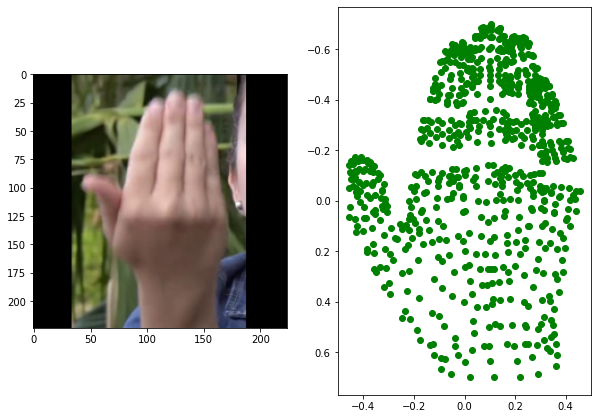

In [111]:
#Check output
fig = plt.figure(figsize=(10,10))
k=0
for ds in ds_train:
    if k==100:
        plt.subplot(121)
        plt.imshow(ds[0][0].numpy())
        ax = fig.add_subplot(122)
        vertex_set = ds[1][0].numpy()
        ax.plot(vertex_set[:, 0], vertex_set[:, 1], "go")
        ax.set_aspect("equal")
        ax.invert_yaxis()
        break
    k+=1
print(k)

In [171]:
##Mesh Sampling

In [112]:
mano = Mano(meta_dir+'MANO_RIGHT.pkl')
v_temp_bbx = bounding_box(mano.V_temp, 0)
MANO_SCALE = tf.convert_to_tensor((v_temp_bbx[1,:]-v_temp_bbx[0,:])/2, dtype=tf.float32)
MANO_SCALE

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.09651165, 0.03064372, 0.08382829], dtype=float32)>

In [113]:
U = []
D = []
import scipy.sparse
for i in range(4):
    u = scipy.sparse.load_npz(meta_dir+'upsampling_matrix'+str(i+1)+'.npz')
    U.append(u)

for i in range(4):
    d = scipy.sparse.load_npz(meta_dir+'downsampling_matrix'+str(i+1)+'.npz')
    D.append(d)

In [114]:
print("sampling transforms", U, D)

sampling transforms [<98x49 sparse matrix of type '<class 'numpy.float64'>'
	with 294 stored elements in Compressed Sparse Column format>, <195x98 sparse matrix of type '<class 'numpy.float64'>'
	with 585 stored elements in Compressed Sparse Column format>, <389x195 sparse matrix of type '<class 'numpy.float64'>'
	with 1167 stored elements in Compressed Sparse Column format>, <778x389 sparse matrix of type '<class 'numpy.float64'>'
	with 2334 stored elements in Compressed Sparse Column format>] [<389x778 sparse matrix of type '<class 'numpy.float64'>'
	with 389 stored elements in Compressed Sparse Column format>, <195x389 sparse matrix of type '<class 'numpy.float64'>'
	with 195 stored elements in Compressed Sparse Column format>, <98x195 sparse matrix of type '<class 'numpy.float64'>'
	with 98 stored elements in Compressed Sparse Column format>, <49x98 sparse matrix of type '<class 'numpy.float64'>'
	with 49 stored elements in Compressed Sparse Column format>]


In [115]:
class SpiralConv(tf.keras.layers.Layer):
    
    def __init__(self, in_channels, out_channels, indices, dim=1):
        super(SpiralConv, self).__init__()
        self.dim = dim
        self.indices = indices
        self.nodes = tf.shape(indices)[0]
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.inp_dense = self.in_channels*tf.shape(indices)[1]
        self.layer = tf.keras.layers.Dense(out_channels)
        
    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        x = tf.reshape(tf.gather(inputs, tf.reshape(self.indices, [-1]), axis=1), [batch_size, self.nodes, self.inp_dense])
        return x
    
    def model(self):
        inputs = tf.keras.Input(shape=(self.nodes, self.in_channels))
        x = self.call(inputs)
        outputs = self.layer(x)
        model = tf.keras.Model(inputs=inputs, outputs=outputs)
        return model

In [116]:
in_channels = 2
out_channels = 3
batch_size = 1
indices = [[0, 1, 2], [1, 2, 0], [2, 1, 0]]
nodes = tf.shape(indices)[0]
inp_dense = in_channels*tf.shape(indices)[1]
inp = [[[0, 0], [1, 1], [-1, -1]]]
out = tf.reshape(tf.gather(inp, tf.reshape(indices, [-1]), axis=1), [batch_size, nodes, inp_dense])
tf.print(out)

[[[0 0 1 1 -1 -1]
  [1 1 -1 -1 0 0]
  [-1 -1 1 1 0 0]]]


In [117]:
class Upsampling(tf.keras.layers.Layer):
    ## Sparse Mult code from coma
    def __init__(self, upsampling_matrix):
        super(Upsampling, self).__init__()
        self.mat = upsampling_matrix
        type(self.mat)
        self.mat = self.mat.tocoo()
        indices = np.column_stack((self.mat.row, self.mat.col))
        self.mat = tf.sparse.SparseTensor(indices, self.mat.data, self.mat.shape)
        self.mat = tf.sparse.reorder(self.mat)
        self.Mp = self.mat.shape[0]
    
    def call(self, inputs):
        N = tf.shape(inputs)[0]
        M = tf.shape(inputs)[1]
        Fin = tf.shape(inputs)[2]
        # N, M, Fin = int(N), int(M), int(Fin)

        x = tf.transpose(inputs, perm=[1, 2, 0])  # M x Fin x N
        x = tf.reshape(x, [M, -1])  # M x Fin*N
        ##Speed up using sparse matrix multiplication
        x = tf.sparse.sparse_dense_matmul(self.mat, x) # Mp x Fin*N
        x = tf.reshape(x, [self.Mp, Fin, -1])  # Mp x Fin x N
        x = tf.transpose(x, perm=[2,0,1]) # N x Mp x Fin
        return x

    # def compute_output_shape(self, input_shape):
    #     new_shape = (input_shape[0], self.Mp,
    #                  input_shape[2])
    #     return new_shape

In [118]:
upml1 = Upsampling(scipy.sparse.csc_matrix.astype(U[-1], dtype=np.float32))
upml2 = Upsampling(scipy.sparse.csc_matrix.astype(U[-2], dtype=np.float32))

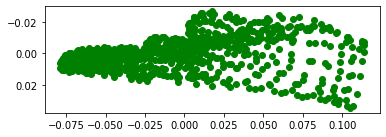

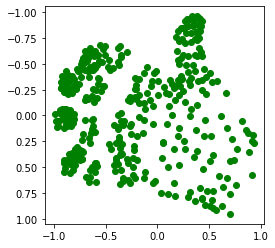

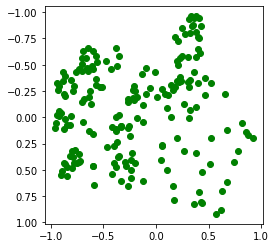

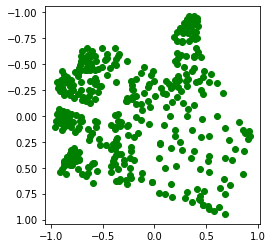

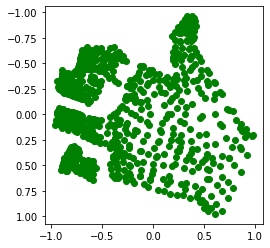

In [119]:
plot_vertices(mano.V_temp)
down_sampled = D[0] @ normalized_vertices[:,:3]
plot_vertices(down_sampled)
down_sampled = D[1] @ down_sampled
plot_vertices(down_sampled)

up_sampled = upml2.call(tf.convert_to_tensor([down_sampled], dtype=tf.float32))
plot_vertices(up_sampled[0])
up_sampled = upml1.call(tf.convert_to_tensor(up_sampled, dtype=tf.float32))
plot_vertices(up_sampled[0])

In [120]:
faces = [[1, 2, 3], [3, 4, 1], [4, 3, 8], [8, 5, 4], [5, 8, 7], [7, 6, 5], [6, 7, 2], [2, 1, 6], [1, 4, 5], [5, 6, 1], [8, 3, 2], [2, 7, 8]]
faces = list(np.array(faces)-1)
edge_mat = get_edge_mat(faces, 8)
print(edge_mat, edge_mat.shape)

[[ 1. -1.  0.  0.  0.  0.  0.  0.]
 [ 0.  1. -1.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0. -1.]
 [ 0.  0.  0.  0.  1.  0.  0. -1.]
 [ 0.  0.  0.  0.  0.  0.  1. -1.]
 [ 0.  0.  0.  0.  1.  0. -1.  0.]
 [ 0.  0.  0.  0.  0.  1. -1.  0.]
 [ 0.  0.  0.  0.  1. -1.  0.  0.]
 [ 0.  1.  0.  0.  0. -1.  0.  0.]
 [ 0.  0.  1. -1.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0. -1.  0.]
 [ 1.  0.  0.  0.  0. -1.  0.  0.]
 [ 1.  0.  0.  0. -1.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0. -1.]
 [ 1.  0.  0. -1.  0.  0.  0.  0.]
 [ 0.  0.  0.  1. -1.  0.  0.  0.]
 [ 1.  0. -1.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0. -1.]] (18, 8)


In [121]:
def get_sparse_edge_mat(edge_mat):
    """
    edge_mat: Num_edges_in_face*778 
    """
    edge_mat = scipy.sparse.csr_matrix(edge_mat)
    edge_mat = edge_mat.tocoo()
    indices = np.column_stack((edge_mat.row, edge_mat.col))
    edge_mat = tf.SparseTensor(indices, edge_mat.data, edge_mat.shape)
    edge_mat = tf.sparse.reorder(edge_mat)
    return edge_mat

In [122]:
tfspm = tf.convert_to_tensor(edge_mat, dtype=tf.float64)
tfspm = get_sparse_edge_mat(edge_mat)
tf.print(tfspm)
## Careful
tensor_edge_mat = tfspm

'SparseTensor(indices=[[0 0]
 [0 1]
 [1 1]
 ...
 [16 2]
 [17 1]
 [17 7]], values=[1 -1 1 ... -1 1 -1], shape=[18 8])'


In [123]:
vertices = [[0, 1, 0], [0, 0, 0], [1, 0, 0], [1, 1, 0], [1, 1, -1], [0, 1, -1], [0, 0, -1], [1, 0, -1]]
y_true = [vertices]
y_true = tf.convert_to_tensor(y_true, dtype=tf.float64)

y_pred = [np.array(vertices)-[0, 1, 0]]
y_pred = tf.convert_to_tensor(y_pred, dtype=tf.float64)

In [124]:
def loss_function(y_true, y_pred):
    num_verts = tf.shape(y_true)[1]
    num_edges = tf.shape(tensor_edge_mat)[0]
    y_true = tf.transpose(y_true, perm=[1, 2, 0]) # 778 x 3 x N
    y_true = tf.reshape(y_true, [num_verts, -1])
    y_pred = tf.transpose(y_pred, perm=[1, 2, 0]) # 778 x 3 x N
    y_pred = tf.reshape(y_pred, [num_verts, -1])
    edge_true = tf.sparse.sparse_dense_matmul(tensor_edge_mat, y_true) # num_edges x 3N
    edge_pred = tf.sparse.sparse_dense_matmul(tensor_edge_mat, y_pred) # num_edges x 3N
    edge_pred = tf.reshape(edge_pred, [num_edges, 3, -1])
    edge_true = tf.reshape(edge_true, [num_edges, 3, -1])
    y_pred = tf.reshape(y_pred, [num_verts, 3, -1]) # 778 x 3 x N
    y_pred = tf.transpose(y_pred, perm=[2, 0, 1]) # N x 778 x 3
    y_true = tf.reshape(y_true, [num_verts, 3, -1])
    y_true = tf.transpose(y_true, perm=[2, 0, 1]) # N x 778 x 3

#     tf.print(tf.shape(y_true), tf.shape(tf.reduce_sum(tf.norm(y_true - y_pred, ord=1, axis=1), axis=0)), tf.shape(tf.reduce_sum(tf.abs(tf.norm(edge_true, ord='euclidean', axis=1)**2 - tf.norm(edge_pred, ord='euclidean', axis=1)**2), axis=0)), output_stream=sys.stdout)
#     tf.print(tf.norm(edge_true, ord='euclidean', axis=1) - tf.norm(edge_pred, ord='euclidean', axis=1) , output_stream=sys.stdout)
#     tf.print(tf.reduce_mean(tf.norm(y_true - y_pred, ord=1, axis=1), axis=-1) , output_stream=sys.stdout)
#     tf.print(tf.reduce_mean(tf.reduce_mean(tf.abs(tf.norm(edge_true, ord=2, axis=1) - tf.norm(edge_pred, ord=2, axis=1)), axis=-1), axis=-1))
#     tf.print(tf.reduce_max(tf.abs(tf.norm(edge_true, ord=2, axis=1) - tf.norm(edge_pred, ord=2, axis=1))), output_stream=sys.stdout)
#     tf.autograph.trace()
#     tf.autograph.trace()

    return tf.reduce_mean(tf.reduce_sum(tf.norm(y_true - y_pred, ord=1, axis=2), axis=1)) + tf.reduce_mean(tf.reduce_sum(tf.abs(tf.norm(edge_true, ord='euclidean', axis=1)**2 - tf.norm(edge_pred, ord='euclidean', axis=1)**2), axis=0))

In [125]:
tf.print(loss_function(y_true, y_pred))

8


In [126]:
sparse_edge_mat = tf.convert_to_tensor(get_edge_mat(mano.triangles, len(mano.V_temp)), dtype=tf.float32)

In [127]:
tensor_edge_mat = get_sparse_edge_mat(sparse_edge_mat)

In [128]:
vertices = mano.V_temp
y_true = [vertices]
y_true = tf.convert_to_tensor(y_true, dtype=tf.float32)

y_pred = [np.array(vertices)-[0, 1, 0]]
y_pred = tf.convert_to_tensor(y_pred, dtype=tf.float32)

In [129]:
tf.print(loss_function(y_true, y_pred))

778


In [130]:
class Error_Metric(tf.keras.metrics.Metric):
    def __init__(self, ann_scale, **kwargs):
        super(Error_Metric, self).__init__(**kwargs)
        self.vertex_distance_error = self.add_weight(name="vertex_dist_error", initializer='zeros')
        self.mean_error = self.add_weight(name="mean_vertex_dist_error", initializer='zeros')
        self.steps = self.add_weight(name="steps", initializer='zeros')
        self.scale = ann_scale

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.vertex_distance_error = tf.reduce_mean(tf.reduce_sum(tf.norm(tf.math.multiply(y_true - y_pred, 1/self.scale), ord=1, axis=2), axis=1)) 
        self.mean_error.assign_add(self.vertex_distance_error)
        self.steps.assign_add(1)

    def result(self):
        return self.vertex_distance_error

    def reset_states(self):
        self.mean_error.assign(0.0)
        self.steps.assign(0.0)

In [131]:
# indices1 = tf.convert_to_tensor(preprocess_spiral(M[-2].f, SEQ_LENGTH), dtype=tf.int32)
# indices2 = tf.convert_to_tensor(preprocess_spiral(M[-3].f, SEQ_LENGTH), dtype=tf.int32)
# indices3 = tf.convert_to_tensor(preprocess_spiral(M[-4].f, SEQ_LENGTH), dtype=tf.int32)
# indices4 = tf.convert_to_tensor(preprocess_spiral(M[-5].f, SEQ_LENGTH), dtype=tf.int32)

In [132]:
# for i in range(4):
#     indices = preprocess_spiral(M[-(i+2)].f, SEQ_LENGTH)
#     with open('indices'+str(i+1)+'.npy', 'wb') as f:
#         np.save(f, indices)

with open(meta_dir+'indices'+str(1)+'.npy', 'rb') as f:
    indices_1 = np.load(f)
with open(meta_dir+'indices'+str(2)+'.npy', 'rb') as f:
    indices_2 = np.load(f)
with open(meta_dir+'indices'+str(3)+'.npy', 'rb') as f:
    indices_3 = np.load(f)
with open(meta_dir+'indices'+str(4)+'.npy', 'rb') as f:
    indices_4 = np.load(f)

In [133]:
def Print(x, name="def"):
    tf.debugging.check_numerics(x, f'${name} FAILS')
    # tf.print(name)
    # tf.print(x)
    return x

In [134]:
resnet50 = tf.keras.applications.ResNet50(
    include_top=True, weights='imagenet', input_tensor=None,
    input_shape=None, pooling=None, classes=1000)

up1 = Upsampling(scipy.sparse.csc_matrix.astype(U[0], dtype=np.float32))
sconv1 = SpiralConv(48, 32, indices_1).model()
up2 = Upsampling(scipy.sparse.csc_matrix.astype(U[1], dtype=np.float32))
sconv2 = SpiralConv(32, 32, indices_2).model()
up3 = Upsampling(scipy.sparse.csc_matrix.astype(U[2], dtype=np.float32))
sconv3 = SpiralConv(32, 16, indices_3).model()
up4 = Upsampling(scipy.sparse.csc_matrix.astype(U[3], dtype=np.float32))
sconv4 = SpiralConv(16, 3, indices_4).model()

In [135]:
inputs = tf.keras.Input(shape=(*OUT_IMAGE_SIZE, 3), name="normalized_image")

In [136]:
x = resnet50(inputs)
x = tf.keras.layers.Lambda(lambda y : Print(y))(x)

In [137]:
# x = tf.keras.layers.Dense(64, activation=tf.keras.activations.relu , name="FC1")(x)
# x = tf.keras.layers.Lambda(lambda y : Print(y))(x)

In [138]:
x = tf.keras.layers.Dense(49*48, activation=tf.keras.activations.relu, name="FC2")(x)
x = tf.keras.layers.Lambda(lambda y : Print(y))(x)

In [139]:
x = tf.keras.layers.Reshape((49, 48), name="reshape_to_mesh")(x)

In [140]:
x = up1(x)
x = tf.keras.layers.Lambda(lambda y : Print(y))(x)

In [141]:
x = sconv1(x)
x = tf.keras.layers.Lambda(lambda y : Print(y))(x)

In [142]:
x = up2(x)
x = tf.keras.layers.Lambda(lambda y : Print(y))(x)

In [143]:
x = sconv2(x)
x = tf.keras.layers.Lambda(lambda y : Print(y))(x)

In [144]:
x = up3(x)
x = tf.keras.layers.Lambda(lambda y : Print(y))(x)

In [145]:
x = sconv3(x)
x = tf.keras.layers.Lambda(lambda y : Print(y))(x)

In [146]:
x = up4(x)
x = tf.keras.layers.Lambda(lambda y : Print(y))(x)

In [147]:
x = sconv4(x)
x = tf.keras.layers.Lambda(lambda y : Print(y))(x)

In [148]:
outputs = x

In [149]:
model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [150]:
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalized_image (InputLayer [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 1000)              25636712  
_________________________________________________________________
lambda (Lambda)              (None, 1000)              0         
_________________________________________________________________
FC2 (Dense)                  (None, 2352)              2354352   
_________________________________________________________________
lambda_1 (Lambda)            (None, 2352)              0         
_________________________________________________________________
reshape_to_mesh (Reshape)    (None, 49, 48)            0         
_________________________________________________________________
upsampling_2 (Upsampling)    (None, 98, None)          0   

In [153]:
## Implement scheduler
learning_rate_fn = keras.optimizers.schedules.PiecewiseConstantDecay(boundaries, lr_values)

callbacks = [
  keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=0,  
    embeddings_freq=0,  
    update_freq="epoch",
  ),
  # keras.callbacks.ModelCheckpoint(
  #       filepath=chkpts_dir+"mymodel_{epoch}",
  #       monitor="val_loss",
  #       verbose=1,
  # )
]

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_fn),
    # loss=tf.keras.losses.MeanAbsoluteError(),
    loss=loss_function,
    metrics=[Error_Metric(1.0)]
)

In [152]:
model.load_weights(chkpts_dir)

OSError: Unable to open file (file read failed: time = Tue Apr 20 23:14:57 2021
, filename = '../chkpts/', file descriptor = 77, errno = 21, error message = 'Is a directory', buf = 0x7ffe1b8e93d0, total read size = 8, bytes this sub-read = 8, bytes actually read = 18446744073709551615, offset = 0)

In [155]:
model.fit(ds_train, epochs=300, validation_data=ds_val, callbacks=callbacks)

# optimizer = keras.optimizers.Adam(learning_rate=learning_rate_fn)

# epochs = 10000
# for epoch in range(epochs):
#     print("\nStart of epoch %d" % (epoch,))

#     for step, (x_batch_train, y_batch_train) in enumerate(ds_train):
#         with tf.GradientTape() as tape:

#             logits = model(x_batch_train, training=True)  # Logits for this minibatch
#             tf.debugging.check_numerics(logits, "logits FAILS")

#             loss_value = loss_function(y_batch_train, logits)
#             # tf.print(loss_value)
#             tf.debugging.check_numerics(loss_value, "loss_value FAILS")

#         grads = tape.gradient(loss_value, model.trainable_weights)
#         for g in grads:
#           # tf.print(tf.shape(g))
#           tf.debugging.check_numerics(g, "Grads FAILS")
#           # tf.print(tf.shape(g), "Mean", tf.math.reduce_mean(g))
#           # tf.print("Variance", tf.math.reduce_std(g))
#         # tf.print(grads)
#         optimizer.apply_gradients(zip(grads, model.trainable_weights))

#         if step % 200 == 0:
#             print(
#                 "Training loss (for one batch) at step %d: %.4f"
#                 % (step, float(loss_value))
#             )

Epoch 1/300
  43/1027 [>.............................] - ETA: 1:58:47 - loss: 715.8344 - error__metric_1: 582.9492

KeyboardInterrupt: 

Test SpiralConv

In [196]:
inputs = tf.keras.Input(shape=(*OUT_IMAGE_SIZE, 3), name="normalized_image")
resnet50 = tf.keras.applications.ResNet50(
    include_top=True, weights='imagenet', input_tensor=None,
    input_shape=None, pooling=None, classes=1000)
resnet_features = resnet50(inputs)

flatten = tf.keras.layers.Flatten()(resnet_features)
dense1 = tf.keras.layers.Dense(778*3)(flatten)
# test_1 = tf.keras.layers.Reshape((389, 3))(dense1)
# test_2 = up4(test_1)
# test_3 = tf.keras.layers.Flatten()(test_2)
relu1 = tf.keras.layers.ReLU()(dense1)
dense2 = tf.keras.layers.Dense(778*3)(relu1)
reshape = tf.keras.layers.Reshape((778, 3), name="V")(dense2)
output = SpiralConv(3, 3, indices_4).model()(reshape)

model1 = tf.keras.Model(inputs=inputs, outputs=output, name="basic_model")
print(model1.summary())

Model: "basic_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalized_image (InputLayer [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 1000)              25636712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 1000)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 2334)              2336334   
_________________________________________________________________
re_lu_1 (ReLU)               (None, 2334)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 2334)              5449890   
_________________________________________________________________
V (Reshape)                  (None, 778, 3)            

In [197]:
learning_rate = 1e-3
boundaries = [100, 130]
lr_values = [learning_rate, learning_rate*0.1, learning_rate*0.01]

learning_rate_fn = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries, lr_values)

model1.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate_fn),
    loss=loss_function,
)

In [186]:
model1.fit(
    ds_train.repeat(), 
    batch_size=1,
    validation_data=ds_val,
    steps_per_epoch = 1,
    epochs=200
)

Epoch 1/200
1/1 [==============================] - 18s 18s/step - loss: 929.8947
Epoch 2/200
1/1 [==============================] - 0s 439ms/step - loss: 869.9859
Epoch 3/200
1/1 [==============================] - 0s 441ms/step - loss: 895.1467
Epoch 4/200
1/1 [==============================] - 0s 439ms/step - loss: 756.4127
Epoch 5/200
1/1 [==============================] - 0s 440ms/step - loss: 763.9094
Epoch 6/200
1/1 [==============================] - 0s 438ms/step - loss: 646.4971
Epoch 7/200
1/1 [==============================] - 0s 439ms/step - loss: 686.1421
Epoch 8/200
1/1 [==============================] - 0s 439ms/step - loss: 562.4730
Epoch 9/200
1/1 [==============================] - 0s 440ms/step - loss: 627.0380
Epoch 10/200
1/1 [==============================] - 0s 439ms/step - loss: 490.0637
Epoch 11/200
1/1 [==============================] - 0s 440ms/step - loss: 591.3499
Epoch 12/200
1/1 [==============================] - 0s 438ms/step - loss: 441.7623
Epoch 13/200
1

Test Upsampling

In [ ]:
inputs = tf.keras.Input(shape=(*OUT_IMAGE_SIZE, 3), name="normalized_image")
resnet50 = tf.keras.applications.ResNet50(
    include_top=True, weights='imagenet', input_tensor=None,
    input_shape=None, pooling=None, classes=1000)
resnet_features = resnet50(inputs)

flatten = tf.keras.layers.Flatten()(resnet_features)
dense1 = tf.keras.layers.Dense(389*3)(flatten)
dense2 = tf.keras.layers.Dense(389*3)(dense1)
test_1 = tf.keras.layers.Reshape((389, 3))(dense2)
test_2 = up4(test_1)
# test_2 = tf.keras.layers.UpSampling1D(2)(test_1)
relu1 = tf.keras.layers.ReLU()(test_2)
reshape = tf.keras.layers.Reshape((778, 3))(relu1)
output = SpiralConv(3, 3, indices_4).model()(reshape)

model2 = tf.keras.Model(inputs=inputs, outputs=output, name="basic_model")
print(model2.summary())

Model: "basic_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalized_image (InputLayer [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 1000)              25636712  
_________________________________________________________________
flatten_18 (Flatten)         (None, 1000)              0         
_________________________________________________________________
dense_43 (Dense)             (None, 1167)              1168167   
_________________________________________________________________
dense_44 (Dense)             (None, 1167)              1363056   
_________________________________________________________________
reshape_15 (Reshape)         (None, 389, 3)            0         
_________________________________________________________________
upsampling_23 (Upsampling)   (None, 778, None)         

In [ ]:
learning_rate = 1e-3
boundaries = [100, 130]
lr_values = [learning_rate, learning_rate*0.1, learning_rate*0.01]

learning_rate_fn = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries, lr_values)

model2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate_fn),
    loss=loss_function,
)

In [ ]:
model2.fit(
    ds_train.repeat(), 
    batch_size=1,
    validation_data=ds_val,
    steps_per_epoch = 1,
    epochs=200
)

Epoch 1/200
1/1 [==============================] - 25s 25s/step - loss: 479.0134
Epoch 2/200
1/1 [==============================] - 1s 739ms/step - loss: 500.3817
Epoch 3/200
1/1 [==============================] - 1s 743ms/step - loss: 471.7463
Epoch 4/200
1/1 [==============================] - 1s 745ms/step - loss: 463.9661
Epoch 5/200
1/1 [==============================] - 1s 742ms/step - loss: 460.2251
Epoch 6/200
1/1 [==============================] - 1s 739ms/step - loss: 455.0601
Epoch 7/200
1/1 [==============================] - 1s 745ms/step - loss: 455.4399
Epoch 8/200
1/1 [==============================] - 1s 740ms/step - loss: 444.4731
Epoch 9/200
1/1 [==============================] - 1s 749ms/step - loss: 442.4014
Epoch 10/200
1/1 [==============================] - 1s 739ms/step - loss: 432.9643
Epoch 11/200
1/1 [==============================] - 1s 741ms/step - loss: 431.7917
Epoch 12/200
1/1 [==============================] - 1s 748ms/step - loss: 423.8737
Epoch 13/200
1

In [ ]:
pred = model.predict(np.array([rotated_and_scaled_image]), batch_size=1)

In [ ]:
viz_3d(pred[0], mano.triangles)

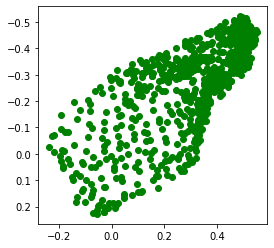

In [ ]:
plot_vertices(pred[0])

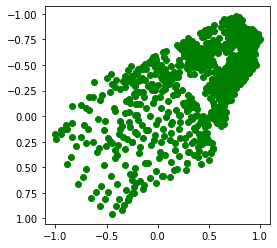

In [ ]:
plot_vertices(up_sampled[0])

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=drive/MyDrive/data/logs2
%reload_ext tensorboard

In [ ]:
len(list(ds_train.as_numpy_iterator()))


11

In [ ]:
model.load_weights(storage_dir+"data/chkpts/mymodel_300")

NotFoundError: ignored